In [ ]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(tidyverse)
library(patchwork)
library(harmony)
library(readxl)
library(viridis)

options(warn = -1)
library(future)
availableCores()
options(future.globals.maxSize = 50 * 1024^4)
plan("multicore", workers = 30)

source('/data/work/01.script/HELP/seurat_help.r/cluster_proportion_trend.R')
source('/data/work/01.script/HELP/seurat_help.r/multi_cluster_volcano.R')

## function

In [19]:
colorlist = c("#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941","#006FA6", "#A30059", "#FFE4E1", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", 
              "#997D87", "#5A0007","#809693", "#1B4400", "#4FC601", "#3B5DFF", "#FF2F80","#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9","#B903AA", 
              "#DDEFFF", "#7B4F4B", "#A1C299", "#0AA6D8","#00A087FF", "#4DBBD5FF", "#E64B35FF", "#3C5488FF", "#F38400","#A1CAF1", "#C2B280", "#848482", 
              "#E68FAC", "#0067A5","#F99379", "#604E97", "#F6A600", "#B3446C", "#DCD300","#882D17", "#8DB600", "#654522", "#E25822", "#2B3D26","#191970", 
              "#000080","#6495ED", "#1E90FF", "#00BFFF", "#00FFFF", "#FF1493","#FF00FF", "#A020F0", "#63B8FF", "#008B8B", "#54FF9F","#00FF00", "#76EE00", "#FFF68F")

# if (length(Cells(combined))>60000) {
#     draw_obj = subset(combined, cells=sample(Cells(combined), 50000))
# } else {
#     draw_obj = combined
# }

plots <- function(obj, group_name, prefix, ...){
    
    colors = colorlist[1:length(unique(obj@meta.data[[group_name]]))]
    names(colors) = unique(obj@meta.data[[group_name]])
    
    p <- DimPlot(obj, group.by=group_name, pt.size=0.1, label.size = 8, cols=colors, raster=F, ...)
    ggsave(paste0(prefix, "_", group_name, ".png"),width=15,height=14, dpi = 300)
    
}

plots_split <- function(obj, draw_obj, group_name, prefix, ...){
    
    if (length(Cells(obj))>60000) {
    draw_obj = subset(obj, cells=sample(Cells(obj), 50000))
    } else {
        draw_obj = obj
    }
    
    colors = colorlist[1:length(unique(obj@meta.data[[group_name]]))]
    names(colors) = unique(obj@meta.data[[group_name]])
    
    pdf(paste0(prefix, "_", group_name, "_split.pdf"))
    for (i in sort(unique(draw_obj@meta.data[[group_name]]))){
        cells = Cells(draw_obj)[draw_obj@meta.data[[group_name]]==i]
        p <- DimPlot(draw_obj, group.by=group_name, cells.highlight=cells)
        print(p+ggtitle(i))
    }
    dev.off()
}


## inte

In [3]:
# 样本整合
samples <- c("p018", "p027", "p028", "p029", "E1", "E2", "E3", "E4" , "M1", "M2", "M3", "M4")

input <- '/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/01.QC'
out <- '/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/02.inte/hmy_0401/'

newname <- 'LUSC'

if(!dir.exists(out)){dir.create(out)}
setwd(out)

In [4]:
obj.list = list() # 创建一个空的列表对象
for (i in samples){
    print(i)
    obj.list[[i]] = readRDS(file.path(input,i, paste0(i,'.rds')))
    obj.list[[i]]$Sample = i
}

combined = merge(obj.list[[1]], obj.list[-1])
#rm(obj.list)
gc()
cat("\nmerge result:\n",capture.output(combined))

[1] "p018"
[1] "p027"
[1] "p028"
[1] "p029"
[1] "E1"
[1] "E2"
[1] "E3"
[1] "E4"
[1] "M1"
[1] "M2"
[1] "M3"
[1] "M4"


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3384565,180.8,5047165,269.6,5047165,269.6
Vcells,1257345501,9592.8,1810122411,13810.2,1810109414,13810.1



merge result:
 An object of class Seurat  39434 features across 80480 samples within 1 assay  Active assay: RNA (39434 features, 0 variable features)

In [ ]:
DefaultAssay(combined) <- "RNA"
combined <- combined %>%
    NormalizeData %>%
    FindVariableFeatures(nfeatures=3000) %>%
    ScaleData %>%
    RunPCA %>%
    RunHarmony(group.by.vars = "Sample") %>%
    FindNeighbors %>%
    FindClusters(resolution=0.5) %>%
    RunUMAP(dims=1:30, reduction = "harmony")

cat("\nmerge result:\n",capture.output(combined))    
saveRDS(combined, paste0(newname, ".rds"))
print("rds saved!")

In [7]:
plots(combined, draw_obj, "seurat_clusters", paste0(newname), label=T)
plots(combined, draw_obj, "sample", paste0(newname))
plots(combined, draw_obj, "type", paste0(newname))

plots_split(combined, draw_obj, "sample", paste0(newname))

In [10]:
plots_split <- function(obj, draw_obj, group_name, prefix, ...){
    
    colors = colorlist[1:length(unique(obj@meta.data[[group_name]]))]
    names(colors) = unique(obj@meta.data[[group_name]])
    
    pdf(paste0(prefix, "_", group_name, "_split.pdf"))
    for (i in sort(unique(draw_obj@meta.data[[group_name]]))){
        cells = Cells(draw_obj)[draw_obj@meta.data[[group_name]]==i]
        p <- DimPlot(draw_obj, group.by=group_name, cells.highlight=cells)
        print(p+ggtitle(i))
    }
    dev.off()
}

In [ ]:
# FindAllMarkers
DefaultAssay(combined) = 'RNA'
marker <- FindAllMarkers(combined, only.pos=T, logfc.threshold = 0.1)
write.csv(marker,paste0(newname,"_markers.csv"))

In [16]:
setwd('/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/02.inte/hmy_0401/')

In [5]:
obj <- readRDS('/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/02.inte/hmy_0401/LUSC.rds')

In [12]:
draw_obj = subset(obj, cells=sample(Cells(obj), 50000))

In [17]:
newname = 'lusc'
plots_split(obj, draw_obj, "seurat_clusters", paste0(newname))

pdf 
  2

In [15]:
getwd()

[1] "/data/work/02.result/others/Chen/proj_lusc/zbl/01.script"

In [8]:
obj$stage <- factor(obj$stage, levels = c('normal','early','middle'))

table(obj$stage,obj$seurat_clusters)

        
             0     1     2     3     4     5     6     7     8     9    10
  normal    95  7498  6428    35     9  4534     0     0     0     0     0
  early    715     0     1  1786  1152    80   512  4109  4002  2932  2799
  middle 11300    21     2  4552  3667   108  3912     7     1    71     0
        
            11    12    13    14    15    16    17    18    19    20    21
  normal     0  2408     5   626  1022   101     0     0   985   792     0
  early   2237     2   265   450   399   458   337  1043     0     5   674
  middle   388    12  1795   878   148   647   836    48     8     5     2
        
            22    23    24    25    26    27    28
  normal     1    77   614     0     1   330   136
  early    553   167     1   372    45    39    80
  middle   101   397     4    93   390    38   137

In [9]:
getwd()

[1] "/data/work/02.result/others/Chen/proj_lusc/zbl/01.script"

In [ ]:
#saveRDS(obj,'LUSC_hmy.rds')

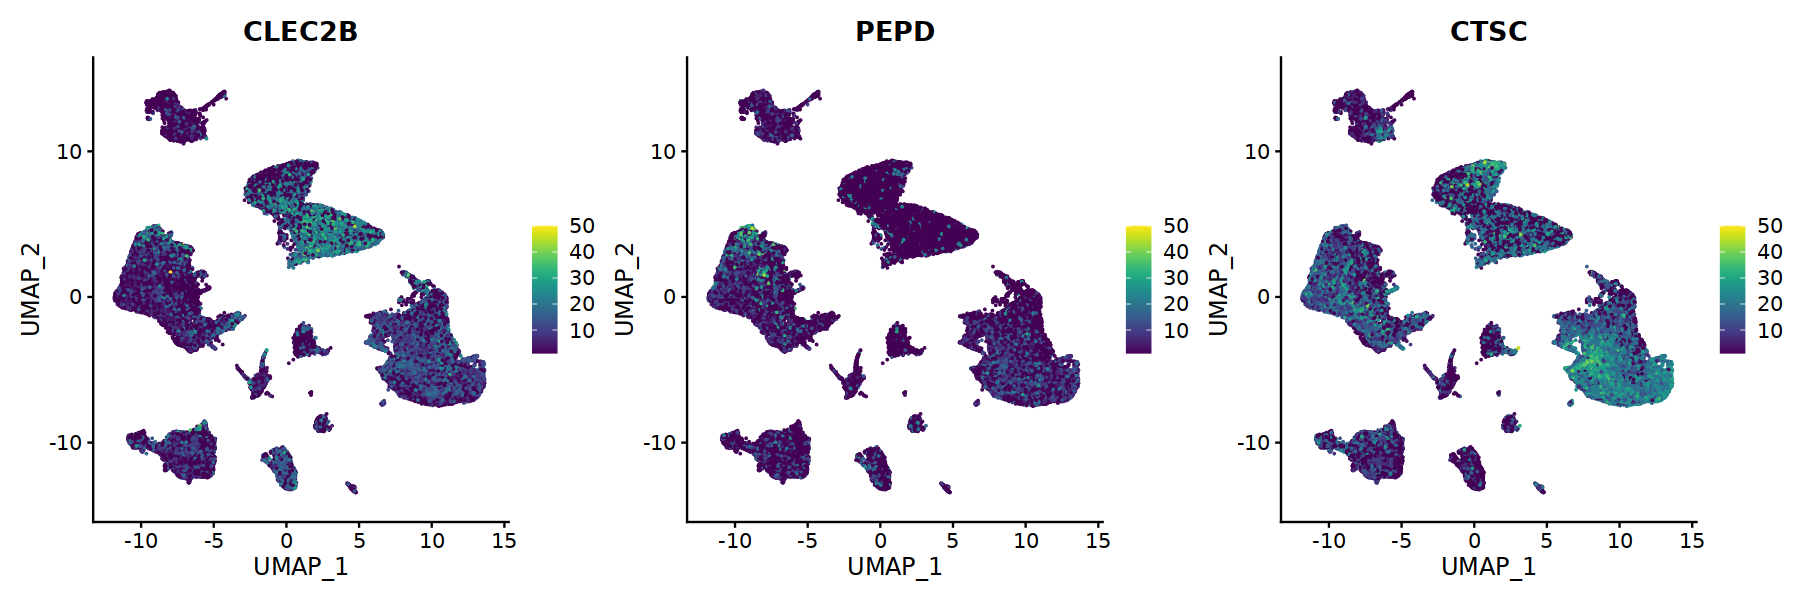

In [16]:
options(repr.plot.width=15,repr.plot.height=5)

p1 <- FeaturePlot(obj, features = c('CLEC2B','PEPD','CTSC'), cols = viridis(50, option = "D"),ncol = 3,  raster = FALSE) #+ labs(subtitle = paste0(celltype, "_marker")) # 
p1
ggsave(paste0("featureplot_CLEC2B-PEPD-CTSC.png"),width=15,height=6, dpi = 100)

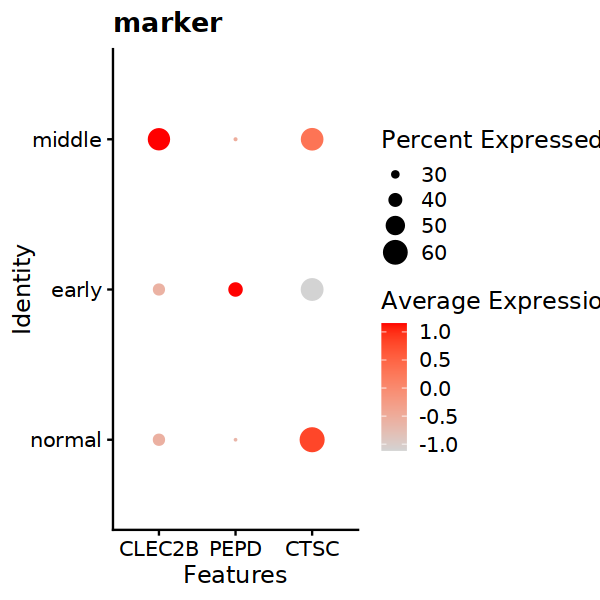

In [17]:
options(repr.plot.width=5,repr.plot.height=5)
#obj$stage <- factor(obj$stage, levels = c('normal','early','middle'))

p2 <- DotPlot(obj, cols = c("lightgrey", "red"),  features = c('CLEC2B','PEPD','CTSC'), group.by = 'stage', cluster.idents = FALSE) + 
              theme(axis.text.x = element_text(angle = 0, hjust = 0.5)) +
              labs(title = "marker")
                   # x = "markers",
                   # y = "Seurat Clusters)

print(p2)
ggsave(paste0("Dotplot_stage_CLEC2B-PEPD-CTSC.png"),width=6,height=15, dpi = 100)

In [ ]:
#obj$stage <- factor(obj$stage, levels = c('normal','early','middle'))

options(repr.plot.width=5,repr.plot.height=10)

p3 <- DotPlot(obj, cols = c("lightgrey", "red"),  features = c('CLEC2B','PEPD','CTSC'), group.by = 'seurat_clusters', cluster.idents = FALSE) + 
              theme(axis.text.x = element_text(angle = 0, hjust = 0.5)) +
              labs(title = "marker")
                   # x = "markers",
                   # y = "Seurat Clusters)

print(p3)
ggsave(paste0("Dotplot_cluster_CLEC2B-PEPD-CTSC.png"),width=6,height=15, dpi = 100)

## FetchData: CLEC2B "Positive" or "Negative"

In [40]:
table(obj$seurat_clusters)


    0     1     2     3     4     5     6     7     8     9    10    11    12 
12110  7519  6431  6373  4828  4722  4424  4116  4003  3003  2799  2625  2422 
   13    14    15    16    17    18    19    20    21    22    23    24    25 
 2065  1954  1569  1206  1173  1091   993   802   676   655   641   619   465 
   26    27    28 
  436   407   353 

In [67]:
obj

An object of class Seurat 
39434 features across 80480 samples within 1 assay 
Active assay: RNA (39434 features, 3000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.6674  1.3437  5.2781 

[1] 0.000000 5.278115

,UMAP_1,UMAP_2,CLEC2B,Group
,<dbl>,<dbl>,<dbl>,<chr>
p018_AAACCCACAACTTGGT-1,12.257452,-4.593280,0,Negative
p018_AAACCCACAAGAATAC-1,10.717210,-7.028401,0,Negative
p018_AAACCCACATCCGGCA-1,8.932329,-6.667165,0,Negative


Length  Class   Mode 
     0   NULL   NULL 


Negative Positive 
   59494    20986 

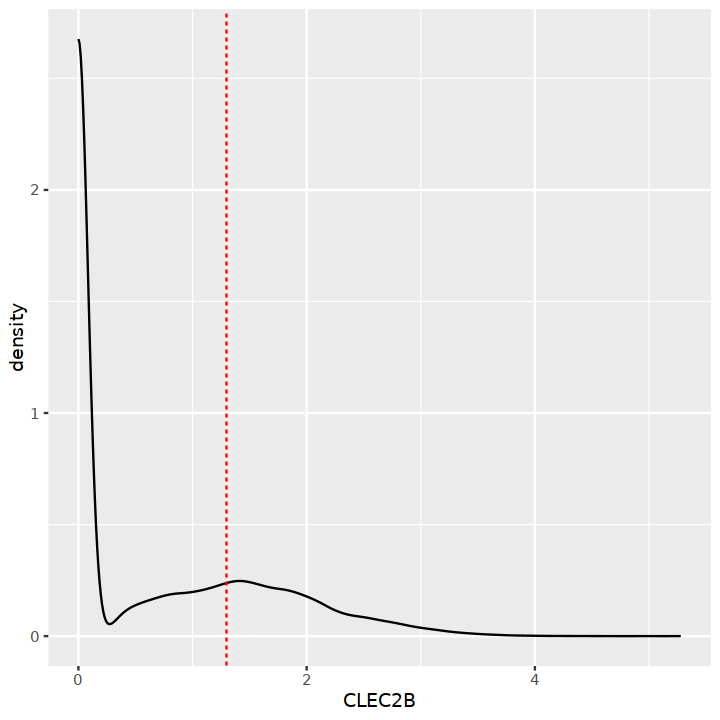

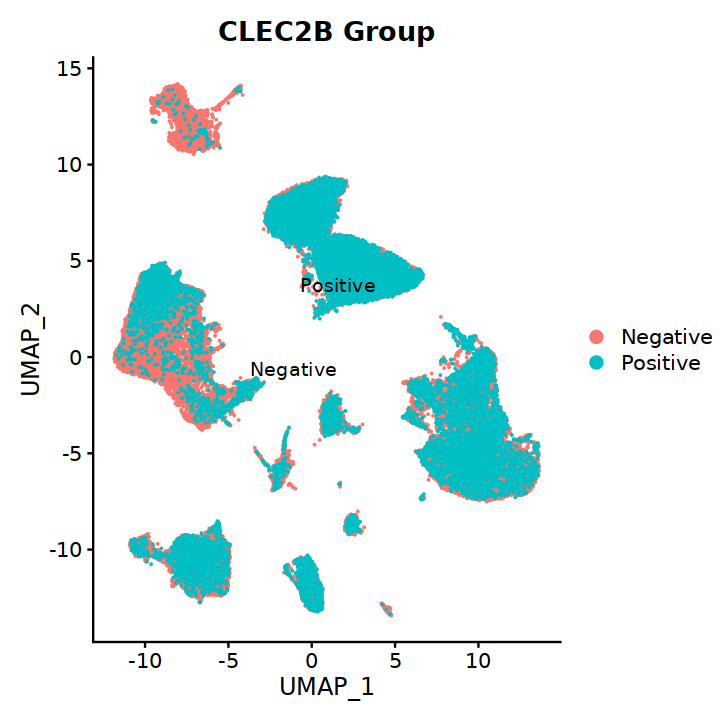

In [68]:
options(repr.plot.width=6,repr.plot.height=6)

# CCL2分组
df <- FetchData(obj, vars=c("UMAP_1","UMAP_2","CLEC2B"),layer="data")
#head(df)

summary(df$CLEC2B)

range(df$CLEC2B)
ggplot(data = df, aes(CLEC2B)) + geom_density()+geom_vline(xintercept = 1.3, linetype="dashed", color="red")

df$Group <- if_else(df$CLEC2B > 1.3, "Positive","Negative")
head(df,3)
summary(df$CCL2)
table(df$Group)


obj2 <- AddMetaData(obj,metadata=df)
#head(obj2,3)

p <- DimPlot(obj2,reduction="umap",group.by="Group",label=T, order=T) + ggtitle("CLEC2B Group")
p

In [50]:
table(obj2$Group,obj2$seurat_clusters)

          
              0    1    2    3    4    5    6    7    8    9   10   11   12
  Negative 8488 6339 6396 5786 4648 4628 4095 3921 3967 2988 2787 1921 2223
  Positive 3622 1180   35  587  180   94  329  195   36   15   12  704  199
          
             13   14   15   16   17   18   19   20   21   22   23   24   25
  Negative 1854 1847 1565 1006 1155  933  963  705  661  432  521  619  457
  Positive  211  107    4  200   18  158   30   97   15  223  120    0    8
          
             26   27   28
  Negative  423  406  330
  Positive   13    1   23

## Epi marker

In [ ]:
# 各亚群特征标记 (精细版)
celltype_markers <- list(
  # 支气管上皮细胞
  "Bronchial" = list(
    "Ciliated" = c("FOXJ1", "PIFO", "DYNC2H1", "CFAP299"),  # 纤毛柱状细胞
    "Goblet" = c("MUC5B", "SCGB1A1", "SPDEF", "TFF3"),      # 杯状细胞
    "Basal" = c("KRT5", "KRT14", "TP63", "ITGA6")           # 基底细胞
  ),
  
  # 鳞状上皮相关
  "Squamous" = list(
    "Normal_Squamous" = c("KRT4", "KRT13", "KRTDAP"),       # 正常鳞状上皮
    "SCC_Proliferative" = c("MKI67", "TOP2A", "PCNA", "CCNB1"),  # 鳞癌增殖亚群
    "SCC_Secretory" = c("SCGB3A1", "SLPI", "LCN2", "LYZ")  # 鳞癌分泌亚群
  ),
  
  # 肿瘤干细胞
  "Cancer_Stem" = c("CD44", "ALDH1A1", "PROM1", "SOX2", "NANOG"),
  
  # 肺泡上皮
  "Alveolar" = list(
    "AT1" = c("AGER", "CAV1", "HOPX", "AQP5"),              # I型肺泡上皮
    "AT2" = c("SFTPC", "SFTPB", "ABCA3", "LAMP3")          # II型肺泡上皮
  ),
  
  # 排除标记
  "Exclusion" = c("PECAM1", "CD45", "DCN", "VIM")
)

# 特异性重点标记 (用于注释)
key_markers <- c(
  "FOXJ1", "MUC5B", "KRT5",                 # 支气管亚型
  "KRT4", "MKI67", "SLPI",                  # 鳞状/鳞癌亚型
  "CD44", "ALDH1A1",                        # 肿瘤干细胞
  "AGER", "SFTPC",                          # 肺泡亚型
  "PECAM1", "CD45"                          # 排除标记
)

## FeaturePlot

In [103]:
table(obj$seurat_clusters)


    0     1     2     3     4     5     6     7     8     9    10    11    12 
12110  7519  6431  6373  4828  4722  4424  4116  4003  3003  2799  2625  2422 
   13    14    15    16    17    18    19    20    21    22    23    24    25 
 2065  1954  1569  1206  1173  1091   993   802   676   655   641   619   465 
   26    27    28 
  436   407   353 

In [98]:
setwd('/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/02.inte/hmy_0401/featureplot')

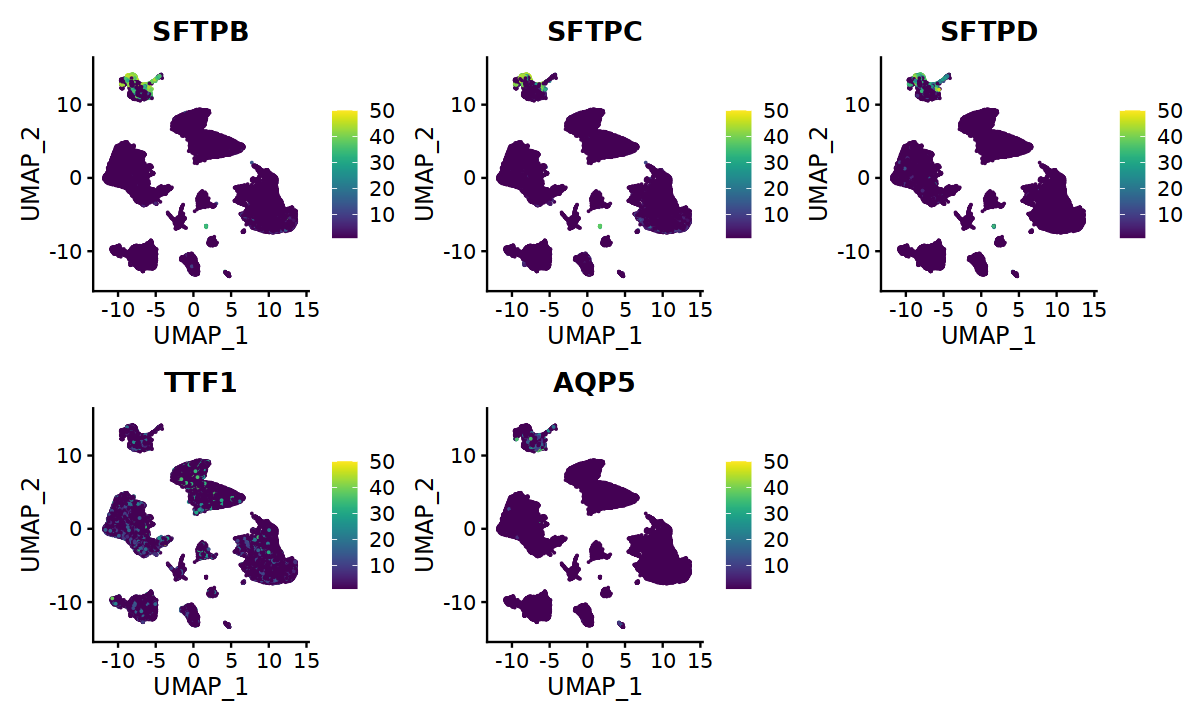

In [105]:
# ATII

ATII_markers <- c(
  "SFTPA",    # 肺表面活性物质蛋白A[^13^]
  "SFTPB",    # 肺表面活性物质蛋白B[^13^]
  "SFTPC",    # 肺表面活性物质蛋白C[^11^][^13^]
  "SFTPD",    # 肺表面活性物质蛋白D[^13^]
  "TTF1",     # 甲状腺转录因子1[^13^]
  "AQP5",     # 水通道蛋白5[^13^]
  "CC10"      # Clara细胞10 kDa分泌蛋白[^13^]
)

options(repr.plot.width=10,repr.plot.height=6)

p2 <- FeaturePlot(obj, features = ATII_markers, cols = viridis(50, option = "D"),ncol = 3,  raster = FALSE) #+ labs(subtitle = paste0(celltype, "_marker")) # 
p2
ggsave(paste0("ATII_featureplot.png"),width=15,height=10, dpi = 100)

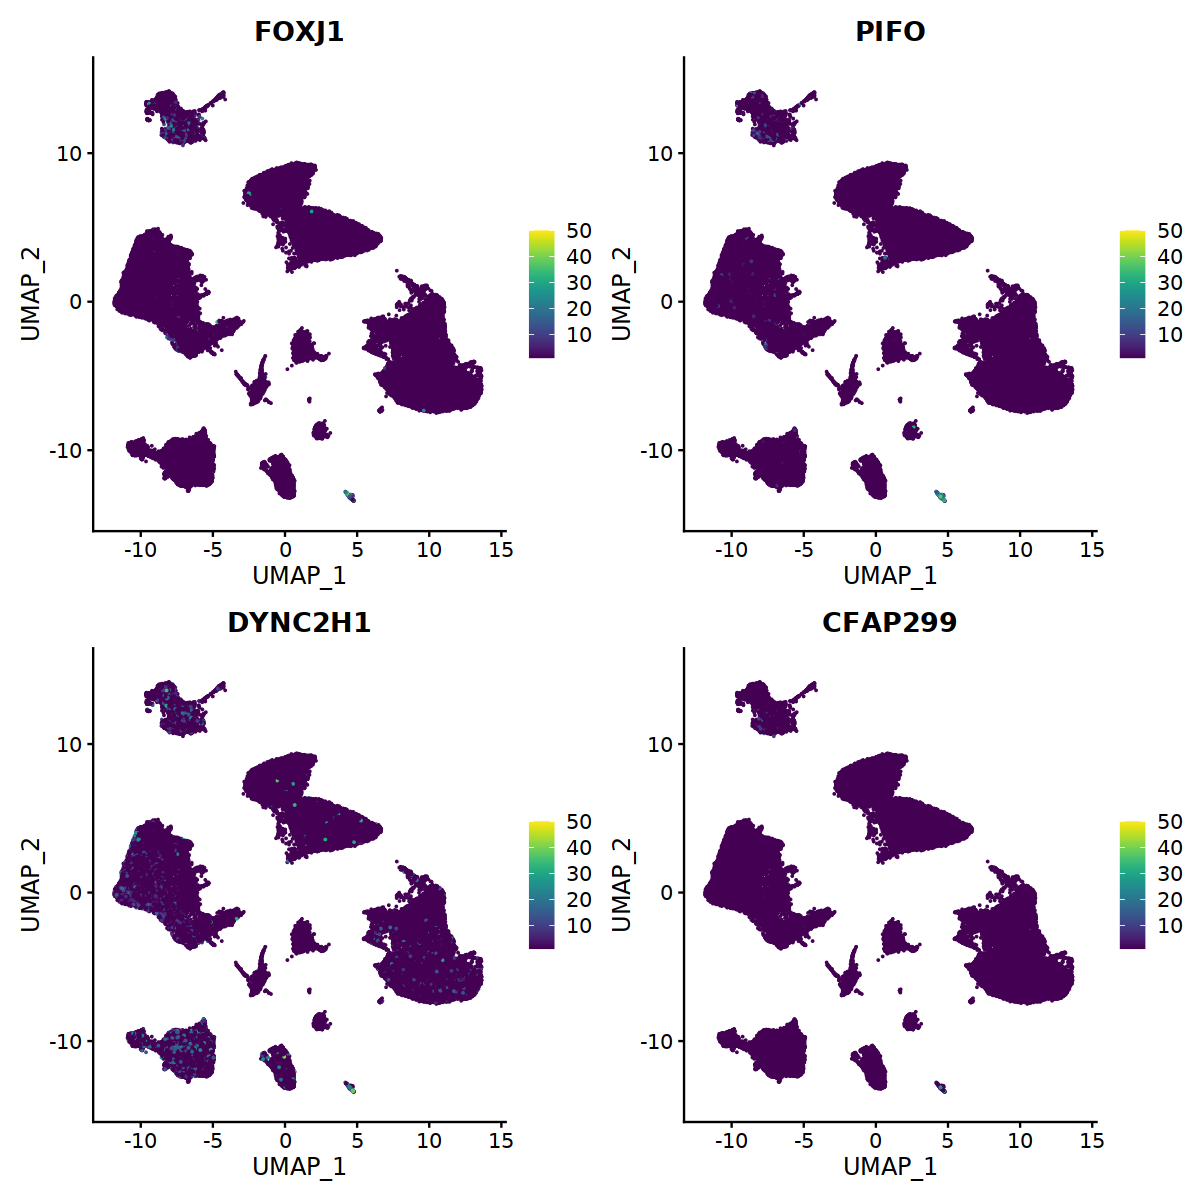

In [106]:
# Ciliated epithelial cells（纤毛上皮细胞）

Ciliated_markers <- c("FOXJ1", "PIFO", "DYNC2H1", "CFAP299")

options(repr.plot.width=10,repr.plot.height=10)

p3 <- FeaturePlot(obj, features = Ciliated_markers, cols = viridis(50, option = "D"),ncol = 2,  raster = FALSE) #+ labs(subtitle = paste0(celltype, "_marker")) # 
p3
ggsave(paste0("Ciliated_Epi_featureplot.png"),width=15,height=15, dpi = 100)


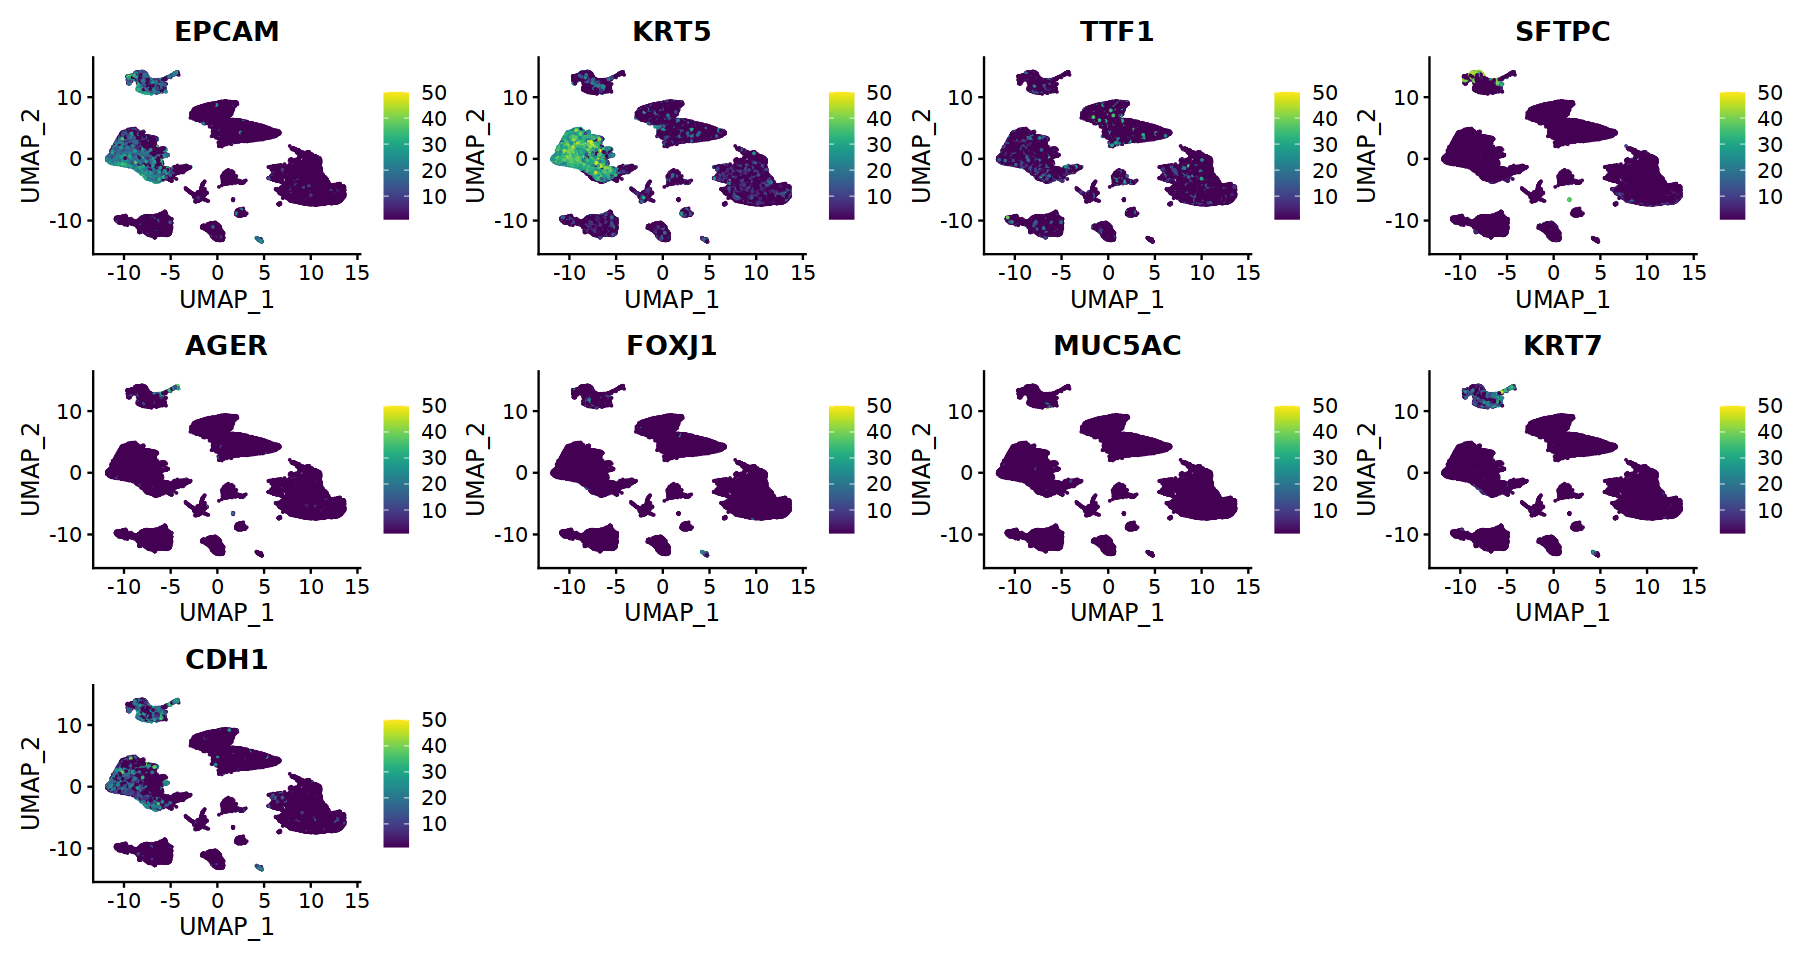

In [96]:
# Epithelial

# 经典上皮细胞大类 Marker（人类肺癌数据）
Epi_markers <- c(
  "EPCAM",       # 泛上皮细胞标记[4,6](@ref)
  "KRT5",        # 基底细胞/鳞状细胞癌（支气管上皮及LUSC）[4,5](@ref)
  "P40",         # 鳞癌特异性标记（TP63同源物）[2,4,5](@ref)
  "TTF1",        # 腺癌特异性标记（肺泡上皮及LUAD）[2,6](@ref)
  "SFTPC",       # II型肺泡上皮细胞（AT2）[4,6](@ref)
  "AGER",        # I型肺泡上皮细胞（AT1）[4](@ref)
  "FOXJ1",       # 纤毛柱状上皮细胞（支气管）[4](@ref)
  "MUC5AC",      # 杯状细胞（支气管）[4](@ref)
  "KRT7",        # 腺癌相关（与鳞癌区分）[2,6](@ref)
  "CDH1"         # 上皮间质转化（EMT）相关，泛上皮连接标记[4](@ref)
)

options(repr.plot.width=15,repr.plot.height=8)

p1 <- FeaturePlot(obj, features = Epi_markers, cols = viridis(50, option = "D"),ncol = 4,  raster = FALSE) #+ labs(subtitle = paste0(celltype, "_marker")) # 
p1
ggsave(paste0("Epi_featureplot.png"),width=16,height=12, dpi = 100)

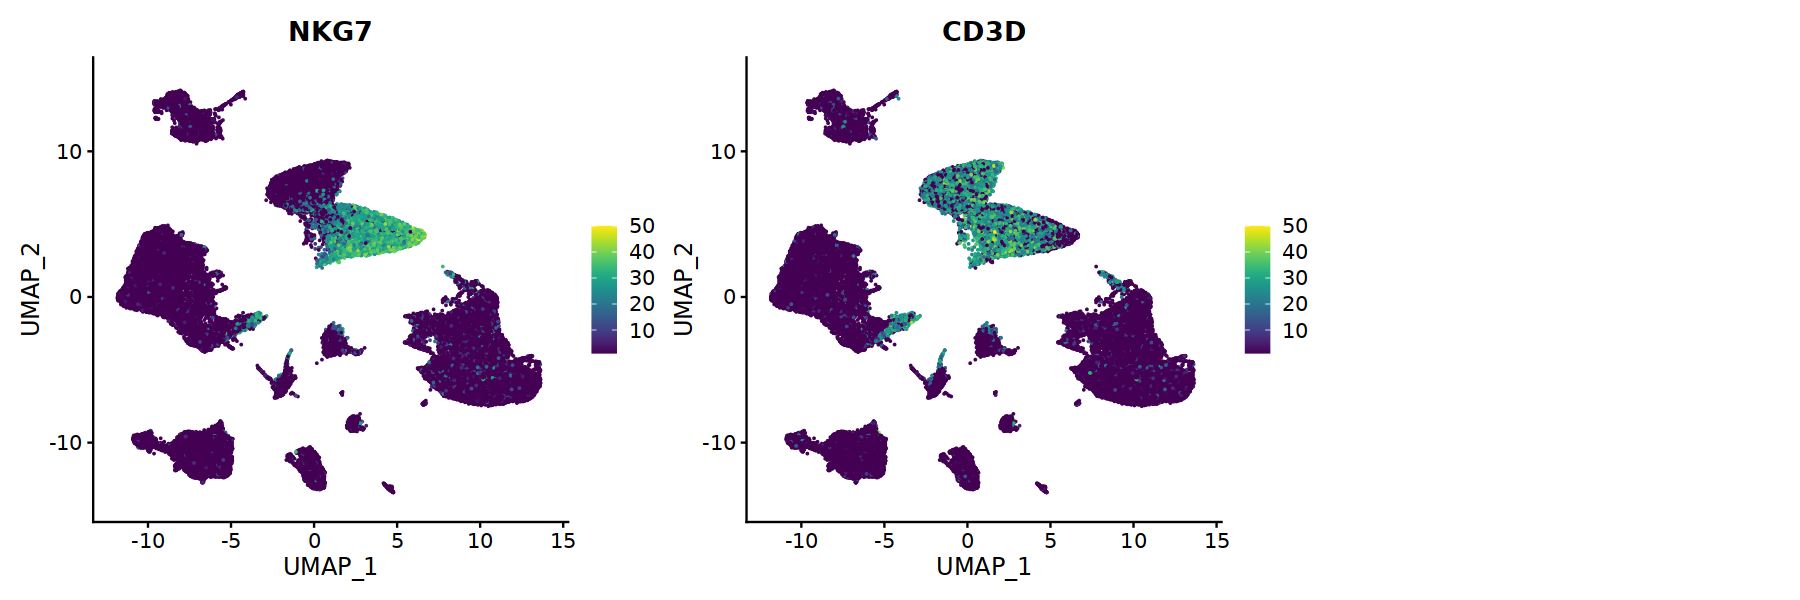

In [66]:
options(repr.plot.width=15,repr.plot.height=5)

p1 <- FeaturePlot(obj, features = c('CD3','NK1.1','CD8','NKG7','CD3D'), cols = viridis(50, option = "D"),ncol = 3,  raster = FALSE) #+ labs(subtitle = paste0(celltype, "_marker")) # 
p1
#ggsave(paste0("featureplot_CLEC2B-PEPD-CTSC.png"),width=15,height=6, dpi = 100)

## orthers plot（multi_cluster_volcano & cluster_proportion_trend）

In [11]:
setwd('/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/02.inte/hmy_0401')

In [12]:
markers <- read.csv('./LUSC_markers.csv')
head(markers)

,X,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,GZMK,0,2.550827,0.413,0.058,0,0,GZMK
2,CCL5,0,2.361477,0.632,0.190,0,0,CCL5
3,TRBC2,0,2.246427,0.723,0.157,0,0,TRBC2
4,CD69,0,2.245775,0.829,0.285,0,0,CD69
5,CD3D,0,2.240016,0.785,0.153,0,0,CD3D
6,IL32,0,2.239709,0.878,0.303,0,0,IL32


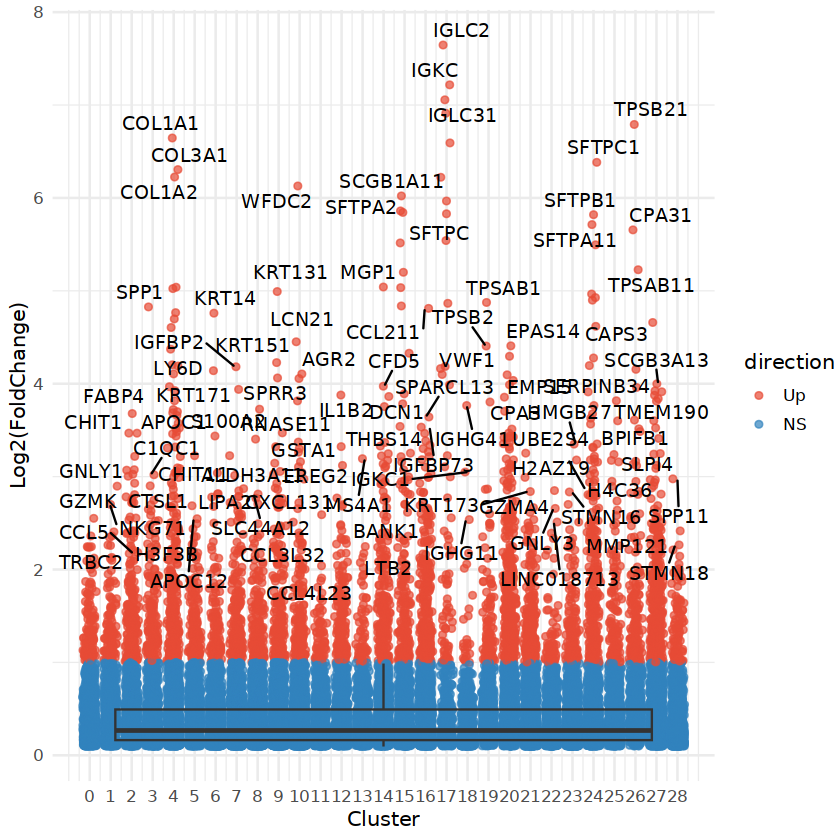

In [13]:
p <- multi_cluster_volcano(markers, plot_style = "combined",top_n = 3)
p
ggsave("volcano_combined.png", p, width = 15, height = 6, dpi = 300)

In [ ]:
cluster_proportion_trend(
  seurat_obj = obj,
  cluster_col = "seurat_clusters",
  group_col = "stage",
  palette_name = "D3", # 尝试更换调色板："Set3","Viridis"
  prefix = "cluster_proportion"
)

In [ ]:
obj <- combined

## self 注释

In [ ]:
# GPT 注释
anno <- as.data.frame(read_excel(paste0("LUSC_anno_GPT.xlsx")))
rownames(anno) = anno$seurat_clusters
obj@meta.data[,'GPT_celltype'] = anno[as.character(obj@meta.data$seurat_clusters),'GPT_celltype']
obj@meta.data[,'GPT_subcelltype'] = anno[as.character(obj@meta.data$seurat_clusters),'GPT_subcelltype']
head(obj)

plots(obj, draw_obj, "GPT_celltype", paste0(newname), label=T)
plots(obj, draw_obj, "GPT_subcelltype", paste0(newname), label=T)

In [108]:
getwd()
setwd('/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/02.inte/hmy_0401')

[1] "/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/02.inte/hmy_0401/featureplot"

In [109]:
# 手动注释 0403

anno <- as.data.frame(read_excel(paste0("./anno_end.xlsx")))
rownames(anno) = anno$seurat_clusters
obj@meta.data[,'sub'] = anno[as.character(obj@meta.data$seurat_clusters),'sub']
obj@meta.data[,'main'] = anno[as.character(obj@meta.data$seurat_clusters),'main']
head(obj,3)


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,pANN_0.25_0.001_489,doublet_info,doublet_score,name,sample,type,⋯,pANN_0.25_0.01_265,pANN_0.25_0.005_359,pANN_0.25_0.005_302,pANN_0.25_0.005_462,pANN_0.25_0.005_393,pANN_0.25_0.01_399,RNA_snn_res.0.5,stage,sub,main
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<chr>
p018_AAACCCACAACTTGGT-1,p018,1982,843,6.861756,0.07692308,Singlet,0.07692308,p018,p018,Normal,⋯,NA,NA,NA,NA,NA,NA,5,normal,Macrophages,Immune
p018_AAACCCACAAGAATAC-1,p018,2508,1061,10.247209,0.30769231,Singlet,0.30769231,p018,p018,Normal,⋯,NA,NA,NA,NA,NA,NA,2,normal,Macrophages,Immune
p018_AAACCCACATCCGGCA-1,p018,2167,1070,11.952007,0.00000000,Singlet,0.00000000,p018,p018,Normal,⋯,NA,NA,NA,NA,NA,NA,5,normal,Macrophages,Immune


In [110]:
newname = 'anno'
plots(obj, "sub", paste0(newname), label=T)
plots(obj, "main", paste0(newname), label=T)
plots_split(obj, draw_obj, "sub", paste0(newname), label=T)

pdf 
  2

In [78]:
# plots_split(obj, draw_obj, "sub", paste0(newname), label=T)
# plots_split(obj, draw_obj, "sample", paste0(newname), label=T)

pdf 
  2

pdf 
  2

In [111]:
obj$stage <- factor(obj$stage, levels = c('normal','early','middle'))

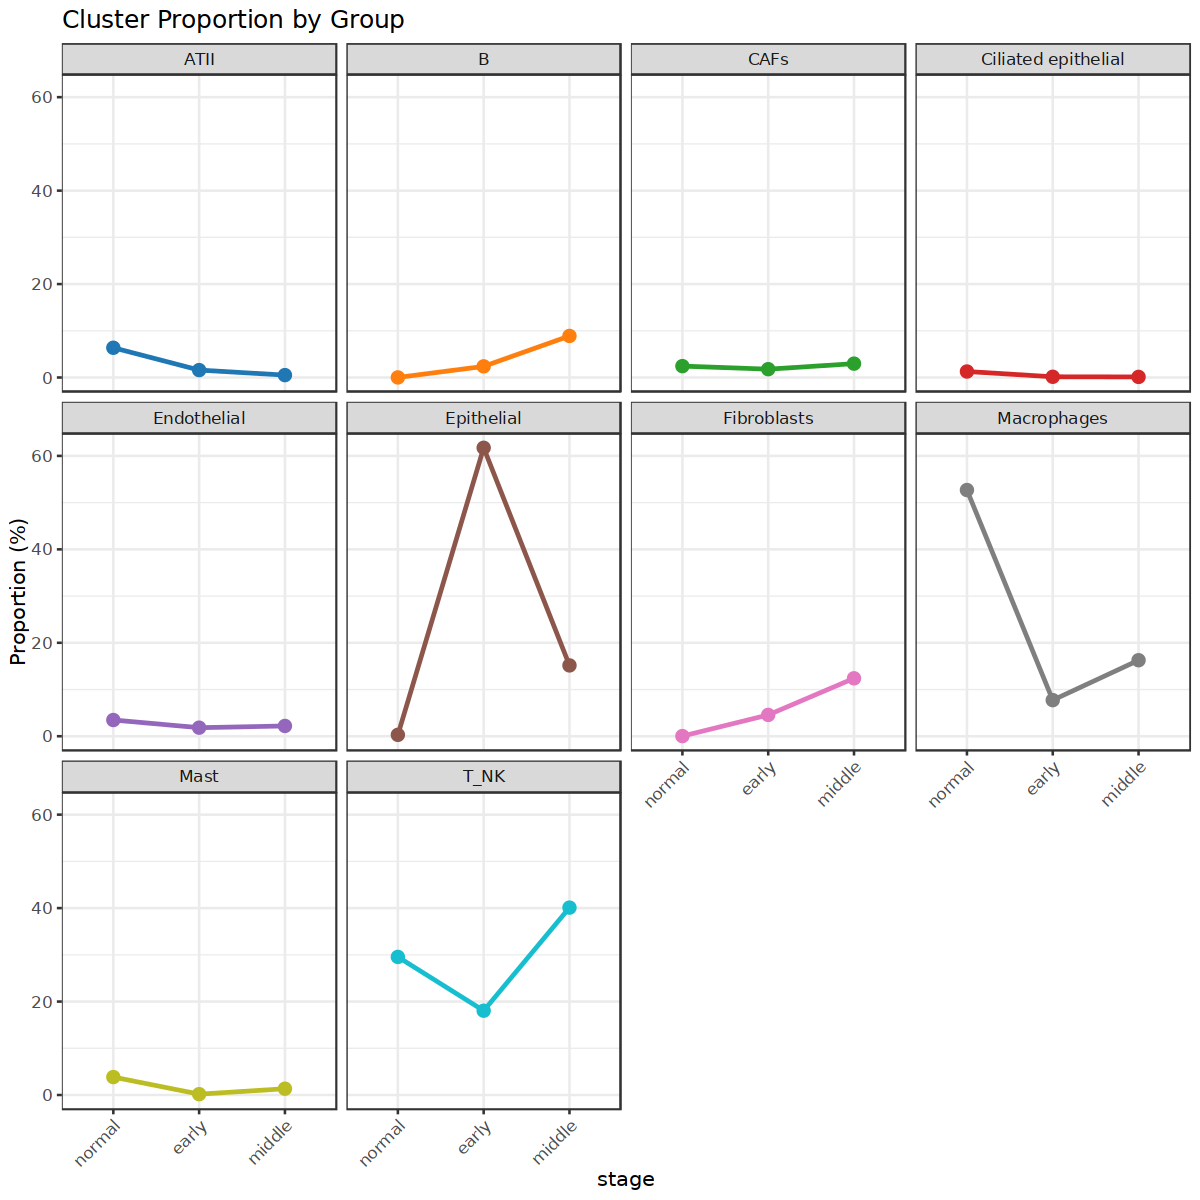

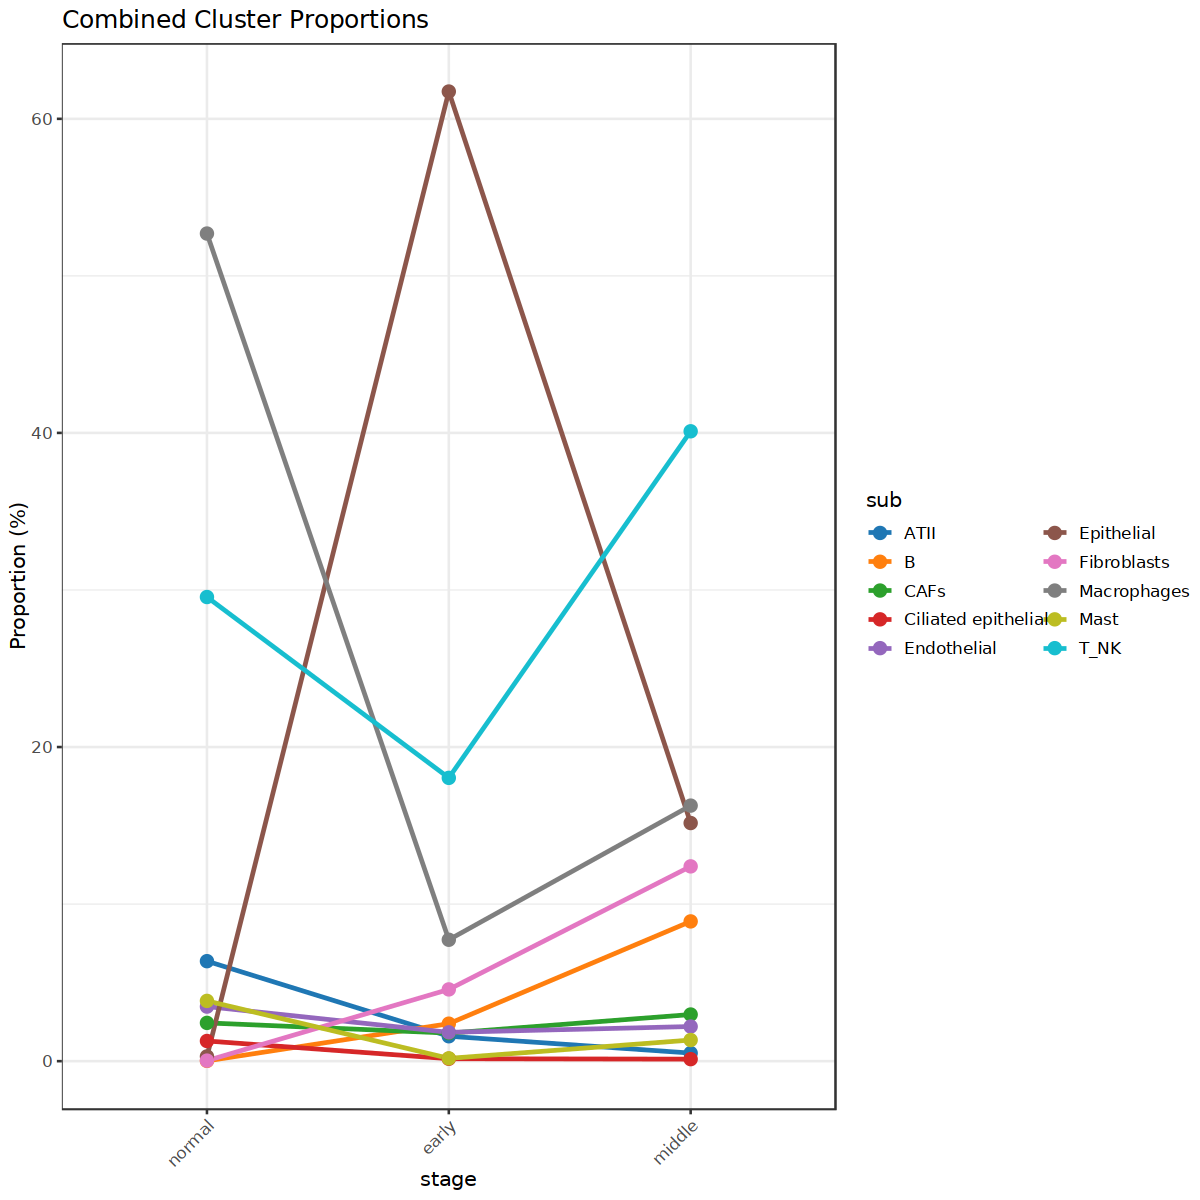

In [112]:
cluster_proportion_trend(
  seurat_obj = obj,
  cluster_col = "sub",
  group_col = "stage",
  palette_name = "D3", # 尝试更换调色板："Set3","Viridis"
  prefix = "sub_stage"
)

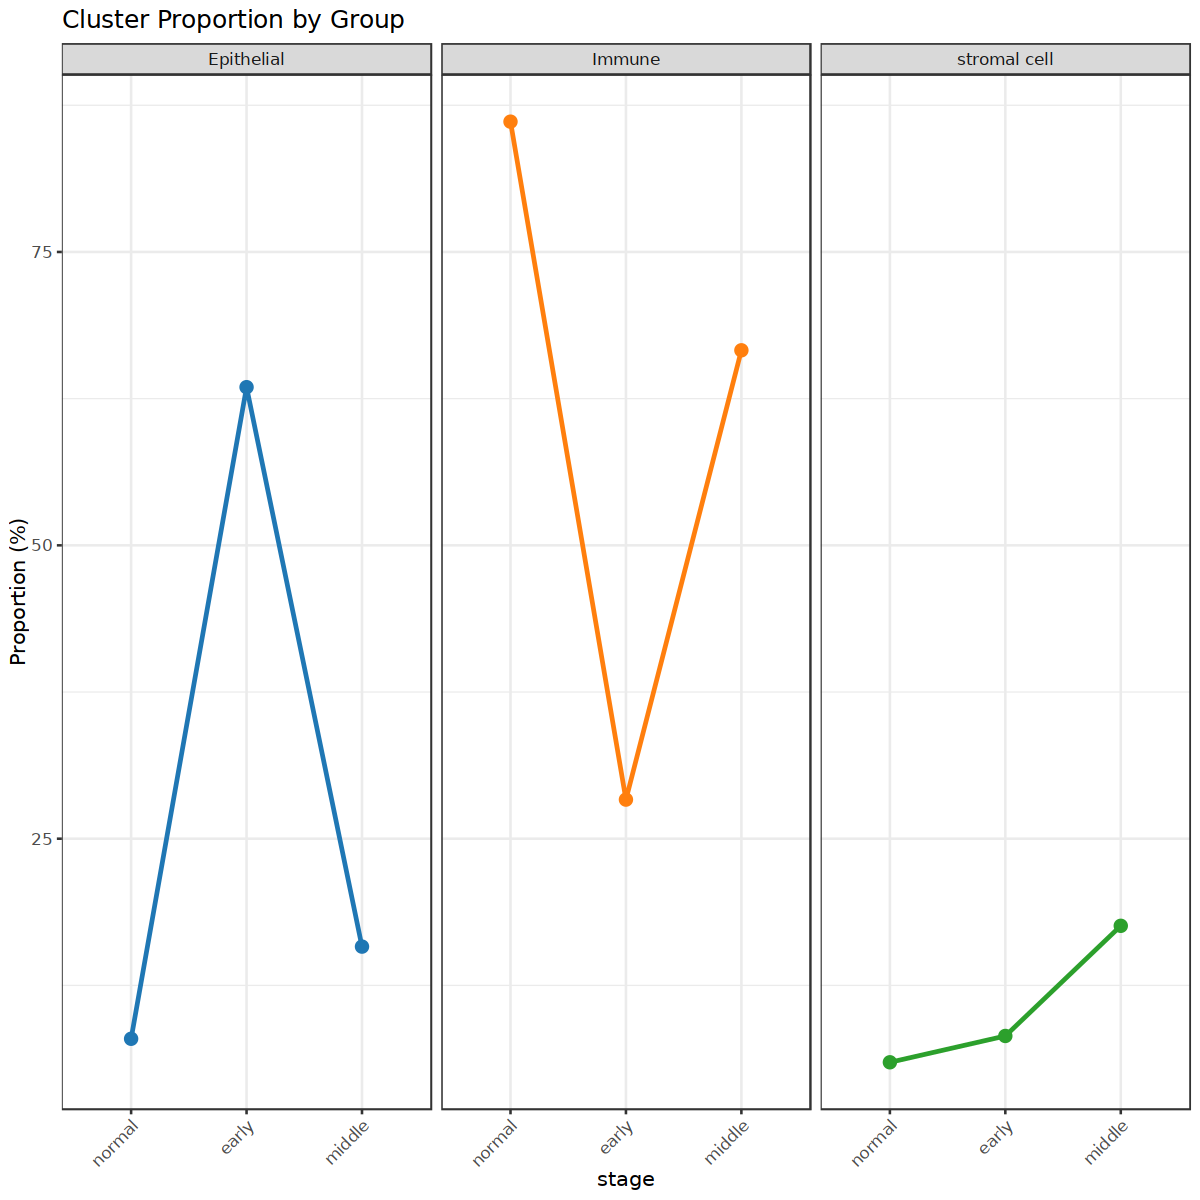

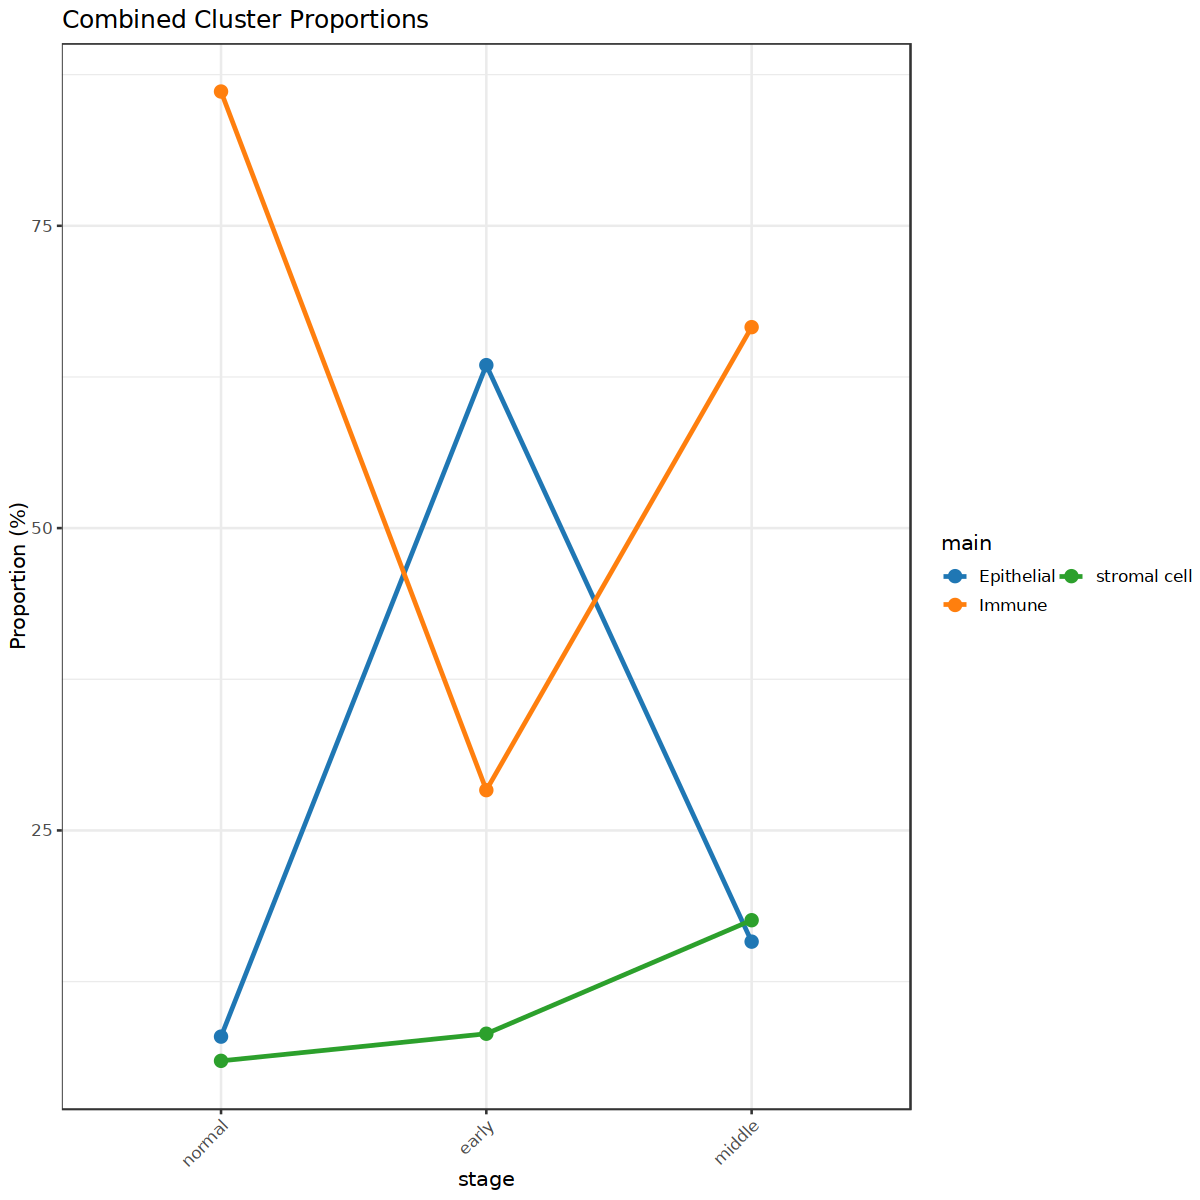

In [113]:
cluster_proportion_trend(
  seurat_obj = obj,
  cluster_col = "main",
  group_col = "stage",
  palette_name = "D3", # 尝试更换调色板："Set3","Viridis"
  prefix = "main_stage"
)

In [114]:
table(obj$stage,obj$sub)

        
          ATII     B  CAFs Ciliated epithelial Endothelial Epithelial
  normal  1636     5   626                 330         893         77
  early    400   602   450                  39         463      15567
  middle   152  2631   878                  38         652       4483
        
         Fibroblasts Macrophages  Mast  T_NK
  normal           9       13541   986  7594
  early         1152        1949    45  4548
  middle        3667        4811   398 11858

In [115]:
table(obj$type,obj$main)

        
         Epithelial Immune stromal cell
  Normal       2043  22126         1528
  Tumor       20679  26842         7262

In [ ]:
head(obj,3)

In [ ]:
unique(obj$name)

In [ ]:
# obj$stage <- ifelse(
#   obj$name %in% c('296C','160C','092C','003C'), 'normal',
#   ifelse(
#     obj$name %in% c('E1','E2','E3','E4'), 'early',
#     ifelse(
#       obj$name %in% c('M1','M2','M3','M4'), 'middle', 
#       NA  # 处理未定义的情况
#     )
#   )
# )

In [117]:
table(obj$stage)


normal  early middle 
 25697  25215  29568 

In [116]:
saveRDS(obj,'LUSC_hmy_0403.rds')  # /data/work/02.result/others/Chen/proj_lusc/zbl/02.result/02.inte/hmy_0401/LUSC_hmy_0403.rds

## umap

In [ ]:
plots(obj, draw_obj, "stage", paste0(newname))

## subset TNK

In [7]:
obj <- readRDS('/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/02.inte/hmy_0401/LUSC_hmy_0403.rds')
obj

An object of class Seurat 
39434 features across 80480 samples within 1 assay 
Active assay: RNA (39434 features, 3000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap

In [12]:
table(obj$stage)
table(obj$seurat_clusters)


normal  early middle 
 25697  25215  29568 


    0     1     2     3     4     5     6     7     8     9    10    11    12 
12110  7519  6431  6373  4828  4722  4424  4116  4003  3003  2799  2625  2422 
   13    14    15    16    17    18    19    20    21    22    23    24    25 
 2065  1954  1569  1206  1173  1091   993   802   676   655   641   619   465 
   26    27    28 
  436   407   353 

In [10]:
Idents(obj) = obj$seurat_clusters
obj_sub <- subset(obj, idents = c('0','1','11','18','22')) # LUSC 中 0 1 11 18 22  高表达 CLEC2B
obj_sub

An object of class Seurat 
39434 features across 24000 samples within 1 assay 
Active assay: RNA (39434 features, 3000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap

In [14]:
unique(obj_sub$seurat_clusters)
unique(obj_sub$name)
unique(obj_sub$stage)

[1] 1  0  22 18 11
29 Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ... 28

[1] "p018" "p027" "p028" "p029" "E1"   "E2"   "E3"   "E4"   "M1"   "M2"  
[11] "M3"   "M4"

[1] normal early  middle
Levels: normal early middle

In [13]:
setwd('/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/02.inte/hmy_0401/sub/NKT')

In [29]:
table(obj_sub$type)


Normal  Tumor 
  7594  16406 

In [ ]:
DefaultAssay(obj_sub) <- "RNA"
obj_sub <- obj_sub %>%
    NormalizeData %>%
    FindVariableFeatures(nfeatures=3000) %>%
    ScaleData %>%
    RunPCA %>%
    RunHarmony(group.by.vars = "Sample") %>%
    FindNeighbors %>%
    FindClusters(resolution=0.5) %>%
    RunUMAP(dims=1:30, reduction = "harmony")


In [30]:
obj_sub

table(obj_sub$seurat_clusters)

An object of class Seurat 
39434 features across 24000 samples within 1 assay 
Active assay: RNA (39434 features, 3000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
4133 2808 2649 2462 2221 2066 1860  963  946  878  815  637  539  525  388  110 

In [17]:
newname = 'NK_T'

plots(obj_sub, "seurat_clusters", paste0(newname), label=T)
plots(obj_sub, "sample", paste0(newname))
plots(obj_sub, "type", paste0(newname))
plots(obj_sub, "stage", paste0(newname))

plots_split(obj_sub, draw_obj, "sample", paste0(newname))
plots_split(obj_sub, draw_obj, "seurat_clusters", paste0(newname))

In [21]:
saveRDS(obj_sub,"NKT.rds")

In [ ]:
# FindAllMarkers
newname = 'NK_T'
DefaultAssay(obj_sub) = 'RNA'
marker <- FindAllMarkers(obj_sub, logfc.threshold = 0.3)
write.csv(marker,paste0(newname,"_markers.csv"))

In [ ]:
options(repr.plot.width=10,repr.plot.height=10)

p1 <- FeaturePlot(obj_sub, features = c('NCAM1','FCGR3A','NCR1','NKG7','CD3D','CD3E','CD3G','CD8A','CD8B'), cols = viridis(50, option = "D"),ncol = 3,  raster = FALSE) #+ labs(subtitle = paste0(celltype, "_marker")) # 
p1
ggsave(paste0("TNK_featureplot.png"),width=15,height=12, dpi = 100)

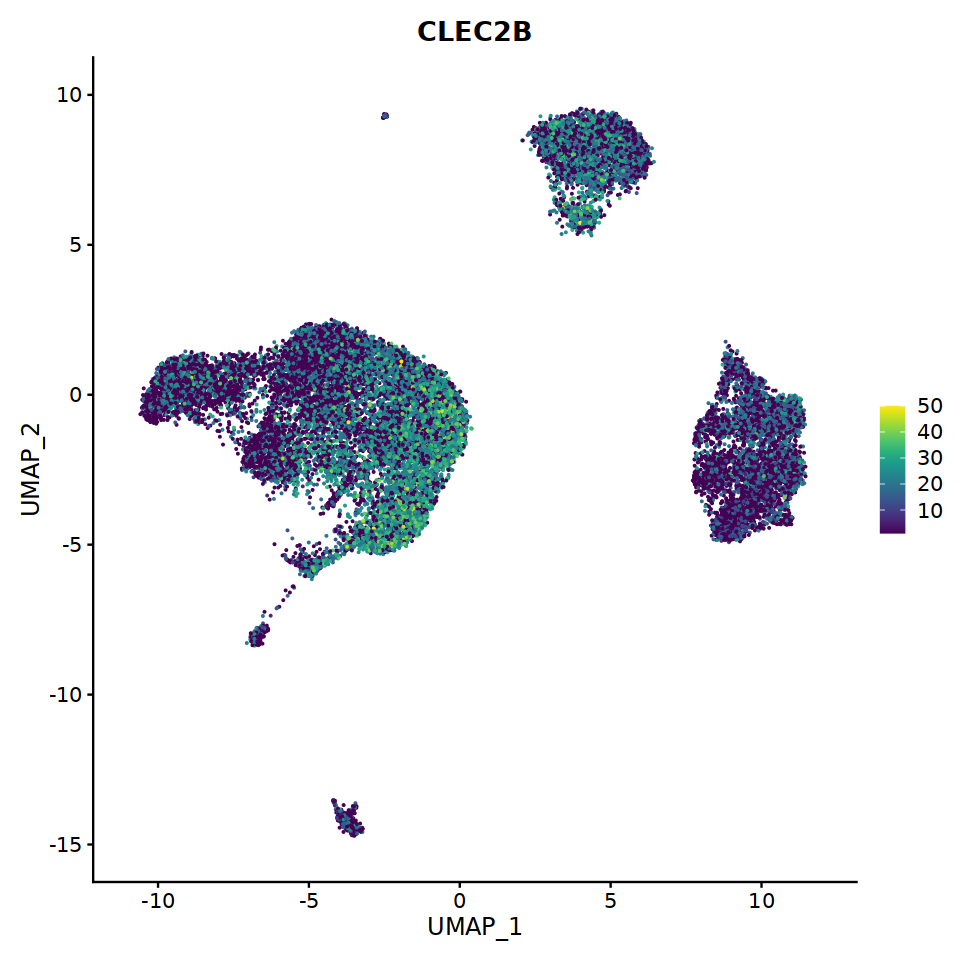

In [26]:
options(repr.plot.width=8,repr.plot.height=8)

p1 <- FeaturePlot(obj_sub, features = c('CLEC2B'), cols = viridis(50, option = "D"),ncol = 1 , raster = FALSE) #+ labs(subtitle = paste0(celltype, "_marker")) # 
p1
ggsave(paste0("NKT_CLEC2B.png"),width=6,height=6, dpi = 100)

#### BATCH = type

In [ ]:
# obj_type <- obj_sub

# setwd('/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/02.inte/hmy_0401/sub/NKT/batchtype')

# DefaultAssay(obj_type) <- "RNA"
# obj_type <- obj_type %>%
#     NormalizeData %>%
#     FindVariableFeatures(nfeatures=3000) %>%
#     ScaleData %>%
#     RunPCA %>%
#     RunHarmony(group.by.vars = "type") %>%
#     FindNeighbors %>%
#     FindClusters(resolution=0.5) %>%
#     RunUMAP(dims=1:30, reduction = "harmony")


# obj_type

# table(obj_type$seurat_clusters)

# newname = 'NK_T'

# plots(obj_type, "seurat_clusters", paste0(newname), label=T)
# plots(obj_type, "sample", paste0(newname))
# plots(obj_type, "type", paste0(newname))
# plots(obj_type, "stage", paste0(newname))

# plots_split(obj_type, draw_obj, "sample", paste0(newname))
# plots_split(obj_type, draw_obj, "seurat_clusters", paste0(newname))

# saveRDS(obj_type,"NKT.rds")

# # FindAllMarkers
# newname = 'NK_T'
# DefaultAssay(obj_type) = 'RNA'
# marker <- FindAllMarkers(obj_type, logfc.threshold = 0.3)
# write.csv(marker,paste0(newname,"_markers.csv"))

# options(repr.plot.width=10,repr.plot.height=10)

# p1 <- FeaturePlot(obj_sub, features = c('NCAM1','FCGR3A','NCR1','NKG7','CD3D','CD3E','CD3G','CD8A','CD8B'), cols = viridis(50, option = "D"),ncol = 3,  raster = FALSE) #+ labs(subtitle = paste0(celltype, "_marker")) # 
# p1
# ggsave(paste0("TNK_featureplot.png"),width=15,height=12, dpi = 100)

# options(repr.plot.width=8,repr.plot.height=8)

# p1 <- FeaturePlot(obj_sub, features = c('CLEC2B'), cols = viridis(50, option = "D"),ncol = 1 , raster = FALSE) #+ labs(subtitle = paste0(celltype, "_marker")) # 
# p1
# ggsave(paste0("NKT_CLEC2B.png"),width=6,height=6, dpi = 100)

## Dotplot

In [39]:
unique(obj_sub$stage)

[1] "normal" "early"  "middle"

In [40]:
obj_sub$stage <- factor(obj_sub$stage, levels = c('normal','early','middle'))

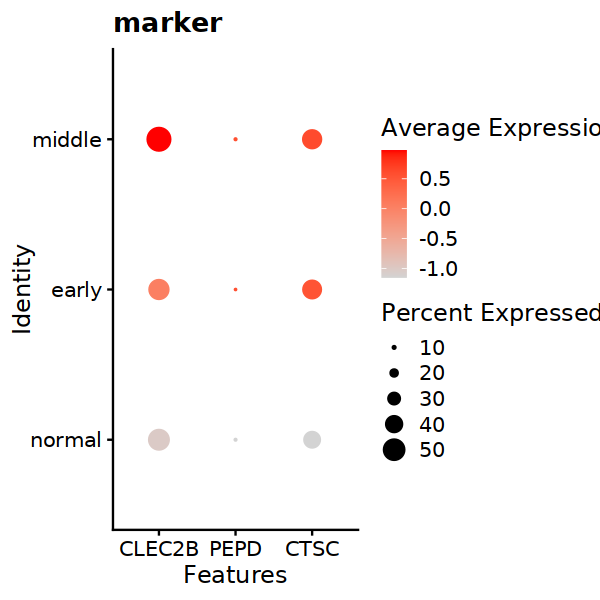

In [41]:
options(repr.plot.width=5,repr.plot.height=5)
#obj$stage <- factor(obj$stage, levels = c('normal','early','middle'))

p2 <- DotPlot(obj_sub, cols = c("lightgrey", "red"),  features = c('CLEC2B','PEPD','CTSC'), group.by = 'stage', cluster.idents = FALSE) + 
              theme(axis.text.x = element_text(angle = 0, hjust = 0.5)) +
              labs(title = "marker")
                   # x = "markers",
                   # y = "Seurat Clusters)

print(p2)
ggsave(paste0("Dotplot_stage_CLEC2B-PEPD-CTSC.pdf"),width=6,height=15, dpi = 100)

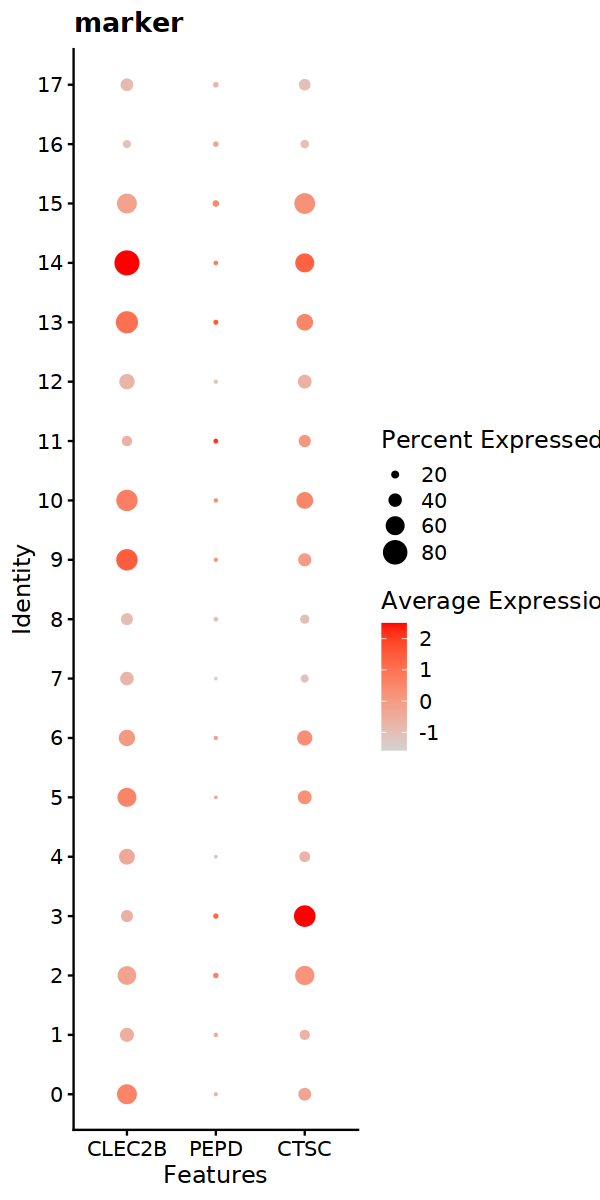

In [42]:
#obj$stage <- factor(obj$stage, levels = c('normal','early','middle'))

options(repr.plot.width=5,repr.plot.height=10)

p3 <- DotPlot(obj_sub, cols = c("lightgrey", "red"),  features = c('CLEC2B','PEPD','CTSC'), group.by = 'seurat_clusters', cluster.idents = FALSE) + 
              theme(axis.text.x = element_text(angle = 0, hjust = 0.5)) +
              labs(title = "marker")
                   # x = "markers",
                   # y = "Seurat Clusters)

print(p3)
ggsave(paste0("Dotplot_cluster_CLEC2B-PEPD-CTSC.pdf"),width=6,height=15, dpi = 100)

In [ ]:
# FindAllMarkers
newname = 'NKT'
DefaultAssay(obj_sub) = 'RNA'
marker <- FindAllMarkers(obj_sub, logfc.threshold = 0.5)
write.csv(marker,paste0(newname,"_markers.csv"))

In [45]:
df <- read.csv('NKT_markers.csv')
head(df)

,X,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,HSPA6,0,2.439561,0.355,0.047,0,0,HSPA6
2,DNAJB1,0,1.805931,0.907,0.627,0,0,DNAJB1
3,HSPA1A,0,1.789855,0.951,0.542,0,0,HSPA1A
4,HSPA1B,0,1.774377,0.927,0.507,0,0,HSPA1B
5,HSPE1,0,1.537927,0.874,0.619,0,0,HSPE1
6,GZMK,0,1.520307,0.696,0.251,0,0,GZMK


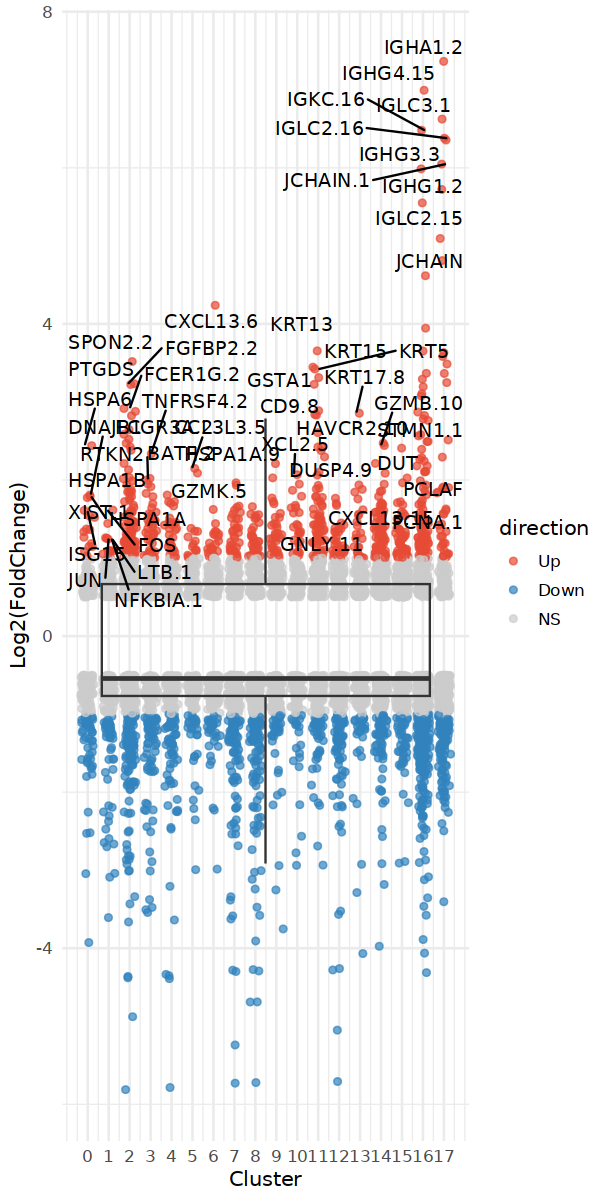

In [51]:
# multi_cluster_volcano.R
p5 <- multi_cluster_volcano(df, plot_style = "combined",top_n = 5)
p5
ggsave("volcano_combined.pdf", p5, width = 20, height = 8, dpi = 300)

## CLEC2B

In [55]:
library(Seurat)
library(ggplot2)
library(ggpubr)

# 假设obj_sub是您的Seurat对象
# 首先提取CLEC2B的表达数据
plot_data <- FetchData(obj_sub, vars = c("CLEC2B", "stage"))
head(plot_data)

,CLEC2B,stage
,<dbl>,<fct>
p018_CCTCCTCCAGCAGAAC-1,0.000000,normal
p018_GATCACACACCACATA-1,0.000000,normal
p018_GTCCCATAGACGCAGT-1,0.000000,normal
p018_TGTTTGTGTGTGTTTG-1,2.176864,normal
p027_AAACCCACACGCTATA-1,0.000000,normal
p027_AAACGAATCGAGGCAA-1,2.042409,normal


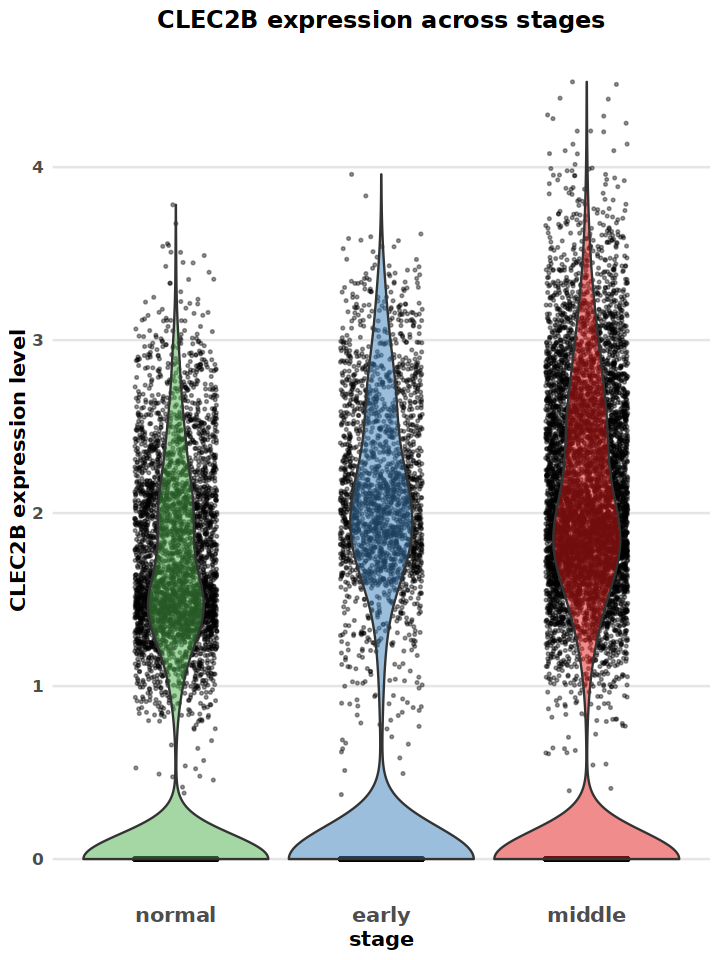

In [66]:
options(repr.plot.width=6,repr.plot.height=8)


# 定义美观的颜色方案
stage_colors <- c("normal" = "#4DAF4A",  # 好看的绿色
                 "early" = "#377EB8",   # 蓝色
                 "middle" = "#E41A1C") # 红色

# 基础绘图
p <- ggplot(plot_data, aes(x = stage, y = CLEC2B, fill = stage)) +
        
        geom_jitter(width = 0.2, alpha = 0.4, size = 0.4, color = "black") +  # 散点(jitter避免重叠)
        geom_violin(scale = "width", trim = TRUE, alpha = 0.5) +  # 半透明小提琴图
        scale_fill_manual(values = stage_colors) +  # 应用自定义颜色
        scale_x_discrete(limits = c("normal", "early", "middle")) + # 确保顺序正确
              labs(
                y = "CLEC2B expression level",
                x = "stage",
                title = "CLEC2B expression across stages"
              ) +
                  theme_minimal(base_size = 12) +
                  theme(
                    legend.position = "none",
                    plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
                    axis.title = element_text(face = "bold", size = 12),  # 坐标轴标题加粗
                    axis.text = element_text(face = "bold", size = 10),  # 坐标轴文本(包括分组标签)加粗
                    axis.text.x = element_text(face = "bold", size = 12), # 特别指定X轴文本加粗
                    panel.grid.major.y = element_line(color = "grey90"),
                    panel.grid.minor.y = element_blank(),
                    panel.grid.major.x = element_blank()
                  )

# 添加统计检验
p1 <- p + stat_compare_means(
  comparisons = list(
    c("normal", "early"),
    c("normal", "middle"),
    c("early", "middle")
  ),
  method = "wilcox.test", # 使用Wilcoxon秩和检验
  label = "p.signif", # 显示显著性标记
  tip.length = 0.01,
  size = 4,
  bracket.size = 0.5,
  step.increase = 0.15
)



p1
# 保存图片
ggsave("CLEC2B_expression_violin.png", plot = p1, width = 6, height = 8, dpi = 300)

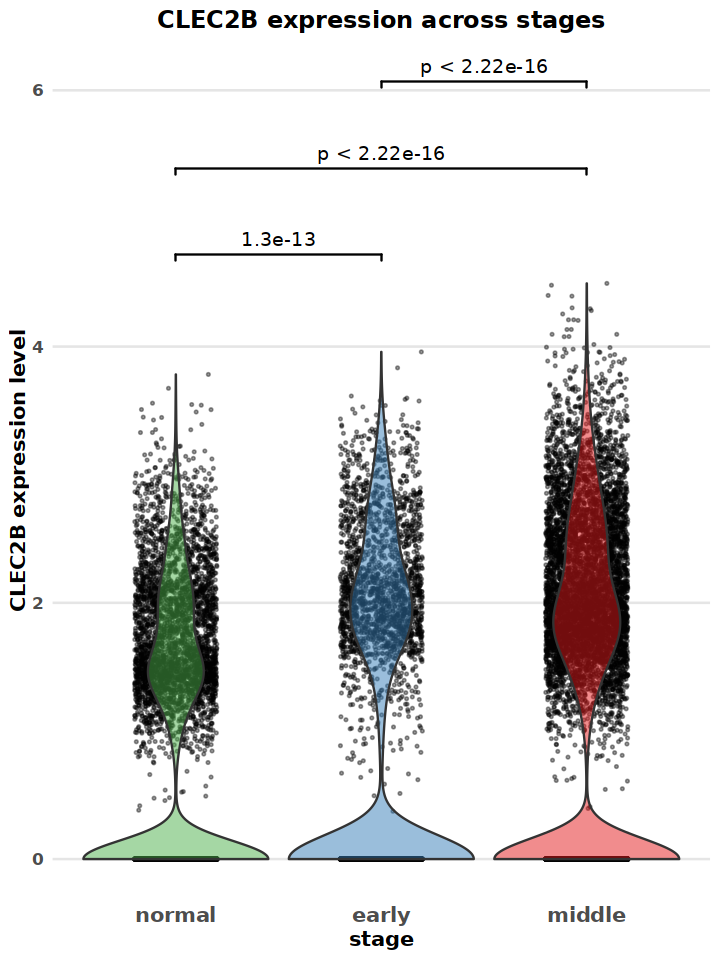

In [68]:
# 添加统计检验
p2 <- p + stat_compare_means(
  comparisons = list(
    c("normal", "early"),
    c("normal", "middle"),
    c("early", "middle")
  ),
  method = "wilcox.test", # 使用Wilcoxon秩和检验
  label = "p = {p.adj}", # 显示显著性标记
  tip.length = 0.01,
  size = 4,
  bracket.size = 0.5,
  step.increase = 0.15
)


p2
# 保存图片
ggsave("CLEC2B_expression_violin_num.pdf", plot = p, width = 6, height = 8, dpi = 300)